In [ ]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# Tip:

Don't focus on variable names. I usually create several to test the results and not lose information.

###Importing the data

In [ ]:
# Radar data
uploaded = files.upload()
df_radar = pd.read_csv('Radar_145eventos.csv') # Csv containing all the radar data for 145 days
df_radar.head()

Saving Radar_145eventos.csv to Radar_145eventos.csv


,Date,Time_match,79809,78367,78368,78847,78848,79327,79328,79329,79807,79808,mean
0,2014-11-24,16:50:00,0.059938,0.0,0.0,0.0,0.0,0.0,0.0,0.141137,0.146740,0.135749,0.025134
1,2014-11-24,16:55:00,0.501779,0.0,0.0,0.0,0.0,0.0,0.0,0.121244,0.116678,0.121244,0.077878
2,2014-11-24,17:00:00,0.717828,0.0,0.0,0.0,0.0,0.0,0.0,0.170499,0.000000,0.261412,0.111041
3,2014-11-24,17:05:00,0.159822,0.0,0.0,0.0,0.0,0.0,0.0,0.056246,0.000000,0.000000,0.027009
4,2014-11-24,17:10:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Level data
uploaded = files.upload()
df_nivel = pd.read_csv('Nivel_145eventos.csv') # Csv containing all the level data for 145 days
df_nivel.head()

Saving Nivel_145eventos.csv to Nivel_145eventos.csv


,Date,Time_match,Level_corr,Temperature
0,2017-12-30,00:00:00,0.9431,23.023
1,2017-12-30,00:05:00,0.9321,23.033
2,2017-12-30,00:10:00,0.9219,23.042
3,2017-12-30,00:15:00,0.9112,23.050
4,2017-12-30,00:20:00,0.9084,23.058


###Merge radar and level data

In [ ]:
df_merged = pd.merge(df_radar, df_nivel, how="inner", on = ['Time_match', 'Date'])

In [ ]:
# Let's use the mean to simplify the analysis

df_final = df_merged.drop(columns=['78367', '78368',	'78847',	'78848',	'79327',	
                                   '79328',	'79329',	'79807',	'79808',	'79809', 'Temperature'])
df_final.head()

,Date,Time_match,mean,Level_corr
0,2014-11-24,16:50:00,0.025134,0.8870
1,2014-11-24,16:55:00,0.077878,0.8850
2,2014-11-24,17:00:00,0.111041,0.8830
3,2014-11-24,17:05:00,0.027009,0.8835
4,2014-11-24,17:10:00,0.000000,0.8840


In [ ]:
df_final['mean'] = df_final['mean']/12 #Let's transform the precipitation (1 hour) into a precipitation for 5 minutes

cols1 = list(df_final.columns)
df_final = df_final[[cols1[0]] + [cols1[1]] + [cols1[3]] + [cols1[2]]]

df_final

,Date,Time_match,Level_corr,mean
0,2014-11-24,16:50:00,0.8870,0.002095
1,2014-11-24,16:55:00,0.8850,0.006490
2,2014-11-24,17:00:00,0.8830,0.009253
3,2014-11-24,17:05:00,0.8835,0.002251
4,2014-11-24,17:10:00,0.8840,0.000000
...,...,...,...,...
12260,2019-04-14,02:00:00,0.8538,0.161907
12261,2019-04-14,02:05:00,0.8523,0.054881
12262,2019-04-14,02:15:00,0.8540,0.022697
12263,2019-04-14,02:20:00,0.8531,0.033621


###Selecting a specific day to analyze (145 days)

In [ ]:
df_specific = df_final.loc[df_final['Date'] == '2015-11-29']

###Mean Rain versus Level

Text(0.5, 1.0, 'Chuva x Nível : 2015-11-29')

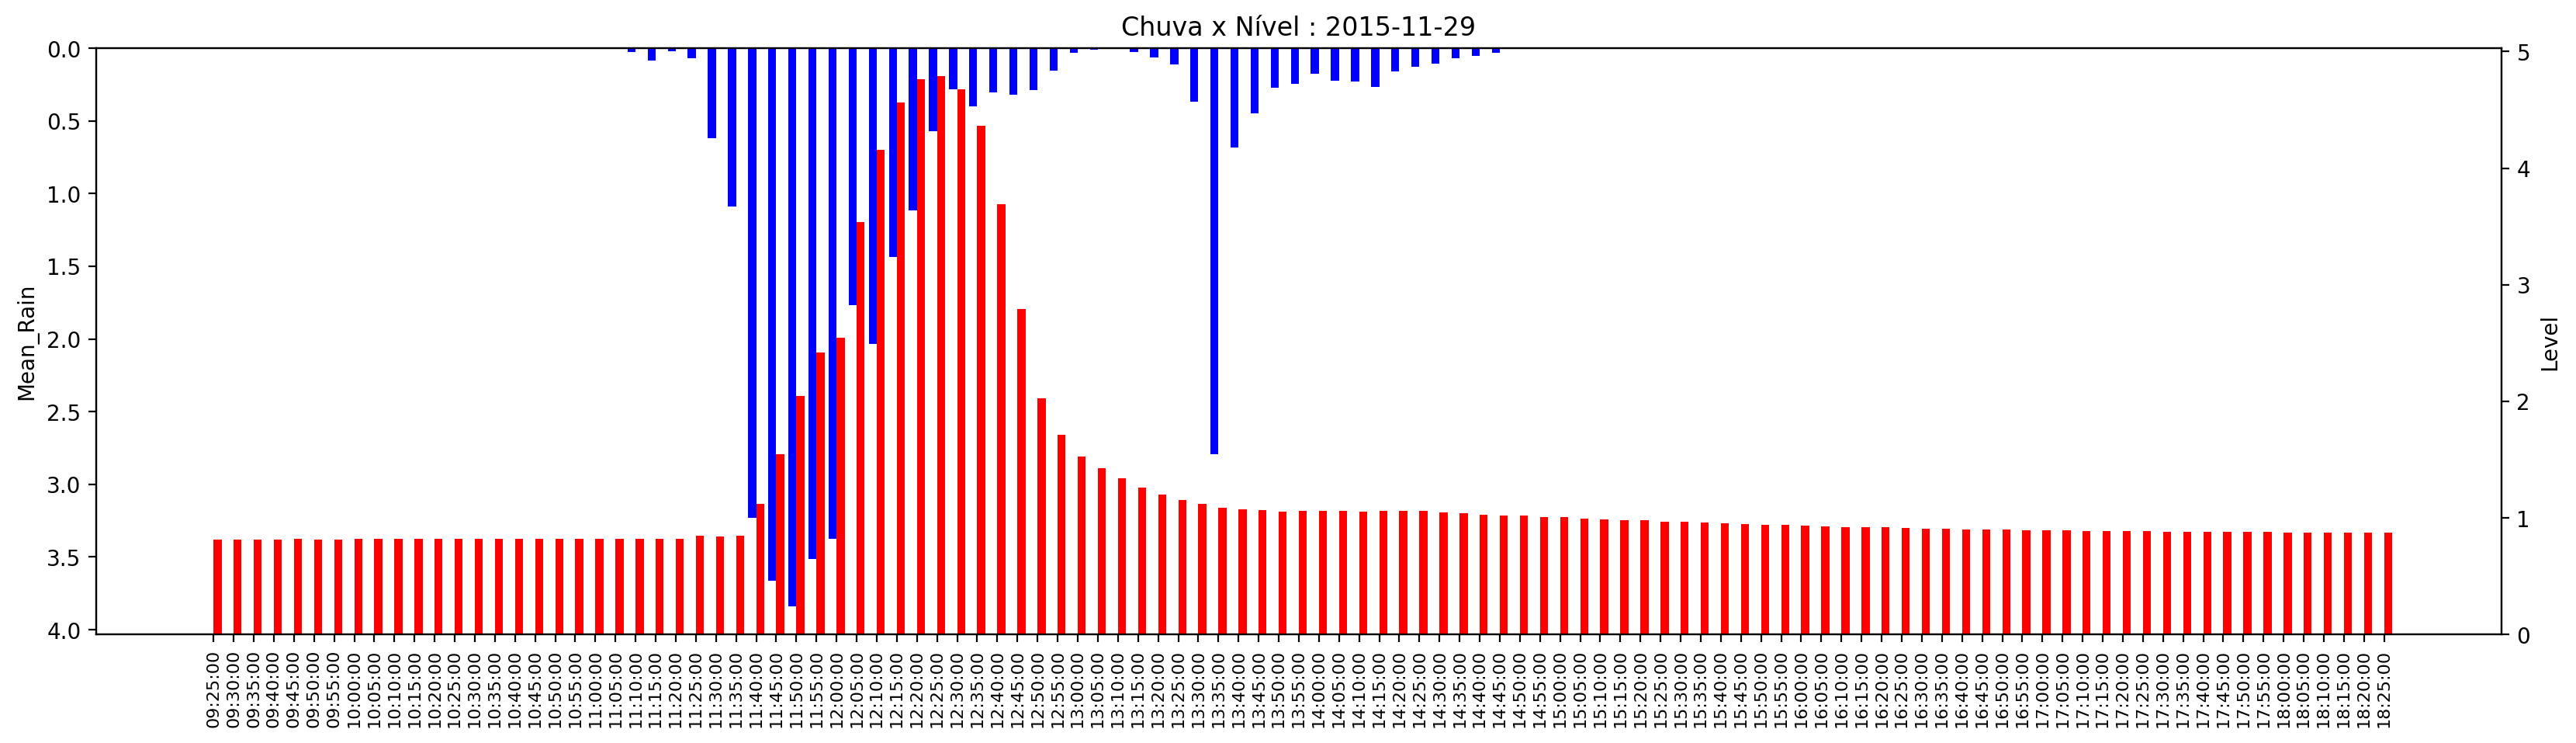

In [ ]:
width = 0.4
figure, left_ax = plt.subplots(figsize=(20, 5), dpi=200)
left_ax.bar(df_specific['Time_match'], df_specific['mean'], color='blue', width=-width, align='edge')
left_ax.set_ylabel('Mean_Rain')
left_ax.invert_yaxis()
plt.xticks(rotation='vertical', size=8)

# Create a Y axis in the right and plot the data
right_ax = left_ax.twinx()
right_ax.bar(df_specific['Time_match'], df_specific['Level_corr'], color='red', width=width, align='edge')
right_ax.set_ylabel('Level')

plt.title("Chuva x Nível : 2015-11-29")

###Correlation between Level and Precipitation

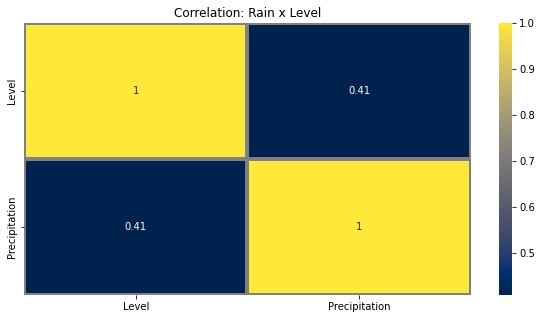

In [ ]:
df_final1 = df_specific.rename(columns = {'Level_corr': 'Level', 'mean': 'Precipitation'})

df_corr = df_final1[['Level', 'Precipitation']].corr()

import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))

plt.title("Correlation: Rain x Level")

hm = sns.heatmap(df_corr, cmap='cividis', linecolor='gray', linewidths=3, ax = ax, annot=True)

###Calculating the lag time

In [ ]:
df_final = df_specific.drop(columns=['Date'])

In [ ]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
                    
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
        df = df.reindex(df.index)  # I had to fix that row to adjust to google colab.
    return df

In [ ]:
NON_DER = ['Time_match']

In [ ]:
df_shifted = df_derived_by_shift(df_final, 36, NON_DER)  # Note that we have already created the X dataframe; 36 is the n° of each 5 minutes = 3 hours; NON_DER is the colum "time"

In [ ]:
df_shifted.head(10)

,Time_match,Level_corr,mean,Level_corr_1,Level_corr_2,Level_corr_3,Level_corr_4,Level_corr_5,Level_corr_6,Level_corr_7,...,mean_27,mean_28,mean_29,mean_30,mean_31,mean_32,mean_33,mean_34,mean_35,mean_36
3973,09:25:00,0.817,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3974,09:30:00,0.816,0.0,0.817,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3975,09:35:00,0.817,0.0,0.816,0.817,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3976,09:40:00,0.816,0.0,0.817,0.816,0.817,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3977,09:45:00,0.818,0.0,0.816,0.817,0.816,0.817,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3978,09:50:00,0.817,0.0,0.818,0.816,0.817,0.816,0.817,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3979,09:55:00,0.817,0.0,0.817,0.818,0.816,0.817,0.816,0.817,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3980,10:00:00,0.818,0.0,0.817,0.817,0.818,0.816,0.817,0.816,0.817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3981,10:05:00,0.819,0.0,0.818,0.817,0.817,0.818,0.816,0.817,0.816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3982,10:10:00,0.819,0.0,0.819,0.818,0.817,0.817,0.818,0.816,0.817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Dropping unused columns
# I chose to advance the rain (first it rains, then the level rises)

df_shifted = df_shifted.drop(columns=["Level_corr_1", "Level_corr_2", "Level_corr_3", "Level_corr_4", "Level_corr_5", "Level_corr_6",
                                      "Level_corr_7", "Level_corr_8", "Level_corr_9", "Level_corr_10", "Level_corr_11", "Level_corr_12",
                                      "Level_corr_13", "Level_corr_14", "Level_corr_15", "Level_corr_16", "Level_corr_17", "Level_corr_18",
                                      "Level_corr_19", "Level_corr_20", "Level_corr_21", "Level_corr_22", "Level_corr_23", "Level_corr_24",
                                      "Level_corr_25", "Level_corr_26", "Level_corr_27", "Level_corr_28", "Level_corr_29", "Level_corr_30",
                                      "Level_corr_31", "Level_corr_32", "Level_corr_33", "Level_corr_34", "Level_corr_35", "Level_corr_36"])

In [ ]:
# Calculating the correlation
df_shifted_cor = df_shifted.corr()
df_shifted_cor.head(10)

,Level_corr,mean,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,...,mean_27,mean_28,mean_29,mean_30,mean_31,mean_32,mean_33,mean_34,mean_35,mean_36
Level_corr,1.000000,0.409523,0.527150,0.641340,0.744261,0.827452,0.884811,0.893929,0.861398,0.786715,...,-0.171039,-0.174103,-0.174826,-0.173569,-0.170860,-0.168037,-0.162710,-0.156584,-0.149806,-0.142862
mean,0.409523,1.000000,0.866730,0.753744,0.602926,0.458459,0.314667,0.214118,0.118545,0.052836,...,-0.119823,-0.115759,-0.113520,-0.114143,-0.117721,-0.129567,-0.136674,-0.145018,-0.149862,-0.151380
mean_1,0.527150,0.866730,1.000000,0.866540,0.753386,0.602337,0.457638,0.313607,0.212876,0.117123,...,-0.115062,-0.122584,-0.118466,-0.116204,-0.116851,-0.120486,-0.132510,-0.139583,-0.147923,-0.152721
mean_2,0.641340,0.753744,0.866540,1.000000,0.866346,0.753020,0.601735,0.456799,0.312523,0.211606,...,-0.084649,-0.117896,-0.125427,-0.121256,-0.118969,-0.119644,-0.123337,-0.135549,-0.142568,-0.150940
mean_3,0.744261,0.602926,0.753386,0.866346,1.000000,0.866148,0.752646,0.601119,0.455941,0.311414,...,-0.049024,-0.087458,-0.120815,-0.128357,-0.124132,-0.121821,-0.122525,-0.126280,-0.138666,-0.145668
mean_4,0.827452,0.458459,0.602337,0.753020,0.866148,1.000000,0.865945,0.752263,0.600489,0.455063,...,0.035379,-0.051748,-0.090352,-0.123824,-0.131379,-0.127099,-0.124764,-0.125499,-0.129299,-0.141904
mean_5,0.884811,0.314667,0.457638,0.601735,0.752646,0.865945,1.000000,0.865738,0.751872,0.599844,...,0.053200,0.032873,-0.054554,-0.093336,-0.126927,-0.134495,-0.130159,-0.127801,-0.128550,-0.132435
mean_6,0.893929,0.214118,0.313607,0.456799,0.601119,0.752263,0.865738,1.000000,0.865526,0.751471,...,0.051575,0.050733,0.030290,-0.057447,-0.096414,-0.130128,-0.137712,-0.133319,-0.130917,-0.131719
mean_7,0.861398,0.118545,0.212876,0.312523,0.455941,0.600489,0.751872,0.865526,1.000000,0.865309,...,0.026169,0.049102,0.048190,0.027628,-0.060430,-0.099589,-0.133433,-0.141034,-0.136562,-0.134154
mean_8,0.786715,0.052836,0.117123,0.211606,0.311414,0.455063,0.599844,0.751471,0.865309,1.000000,...,0.000617,0.023629,0.046553,0.045569,0.024882,-0.063509,-0.102867,-0.136846,-0.144443,-0.139931


In [ ]:
df_teste = df_shifted_cor.iloc[1:, 0] #Selecting the all the lines and the first column (each lag-time versus correlation value)

df_teste.to_frame()
df_teste = df_teste.reset_index()

for k, i in enumerate(df_teste['index']):

  df_teste.at[k, 'index'] = k*5 #Creating the lag time in total minutes (Displacement x 5 minutes)

df_teste

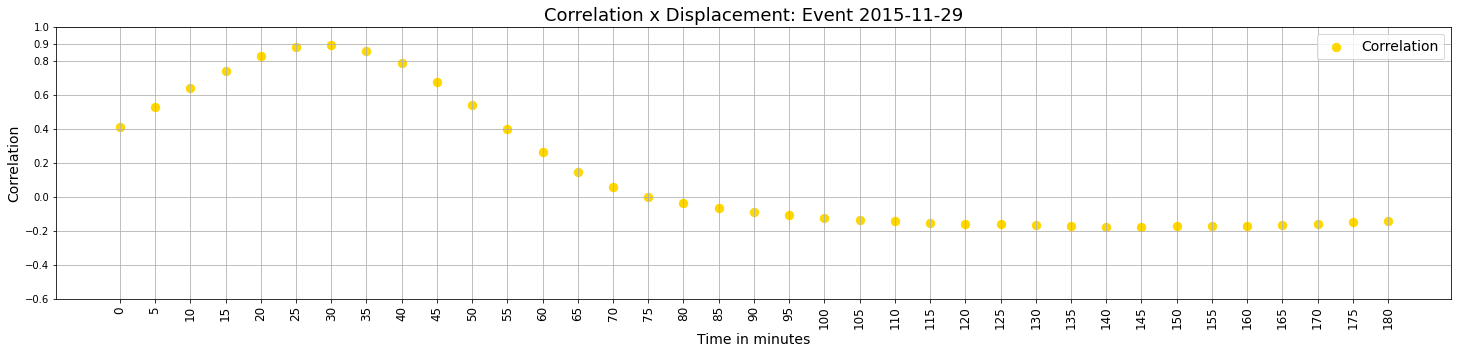

In [ ]:
# Ploting the lag time
df_teste.plot.scatter(x="index", y="Level_corr", figsize=(25, 5), s=70, color='gold')

plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 
            100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180], rotation='vertical', size=12)
plt.yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
plt.ylabel('Correlation', size = 14)

plt.xlabel('Time in minutes', size = 14)
plt.legend(['Correlation'], fontsize=14)

plt.title("Correlation x Displacement: Event 2015-11-29", fontsize=18)

plt.grid()